# 2025-09-05 Convergence classes

* Rootfinding as a modeling tool

* Limitations of bisection

* Convergence classes

* Intro to Newton methods

See also [FNC](https://tobydriscoll.net/fnc-julia/nonlineqn/fixed-point.html#linear-convergence)

## Stability: Volume of a polygon

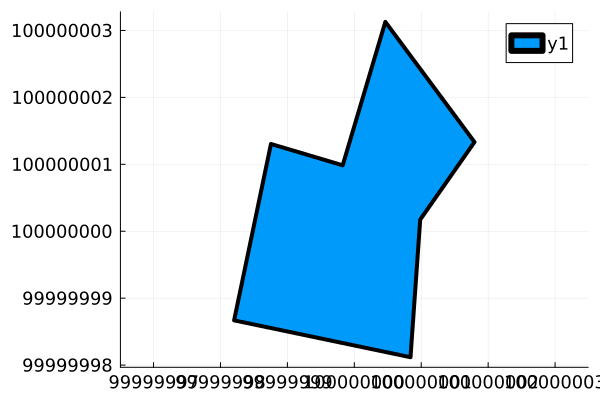

In [1]:
# What is the area of this polygon?
using Plots
default(lw=4, ms=5, legendfontsize=12, xtickfontsize=12, ytickfontsize=12)

X = ([1 0; 2 1; 1 3; 0 1; -1 1.5; -2 -1; .5 -2; 1 0])

R(θ) = [cos(θ) -sin(θ); sin(θ) cos(θ)]
Y = X * R(deg2rad(10))' .+ [1e8 1e8]

plot(Y[:,1], Y[:,2], seriestype=:shape, aspect_ratio=:equal)

In [2]:
using LinearAlgebra

function pvolume(X)
    n = size(X, 1)
    vol = sum(det(X[i:i+1, :]) / 2 for i in 1:n-1)
end

@show vol_X = pvolume(X)
@show vol_Y = pvolume(Y);

vol_X = pvolume(X) = 9.25
vol_Y = pvolume(Y) = 8.022769168019295


Why is the first digit wrong?
These values are ~$10^8$ and $\epsilon_\text{machine} \approx 10^{-16}$ so shouldn't we get about 8 correct digits?

Answer: In the determinant, we are are multiplying values ~$10^8$ to get values ~$10^{16}$ and subtracting them.

## Rootfinding

> Given $f \left( x \right)$, find $x_*$ such that $f \left( x_* \right) = 0$.

We are working with scalars for now and will revisit vector valued functions later.

* We don't have $f \left( x \right)$ but rather the algorithm `f(x)` that approximates it.

* Sometimes we have extra information, such as `fp(x)` that approximates $f' \left( x \right)$.

* If we have the source code for `f(x)`, we might be able to transform it to provide `fp(x)`.

### Iterative Bisection

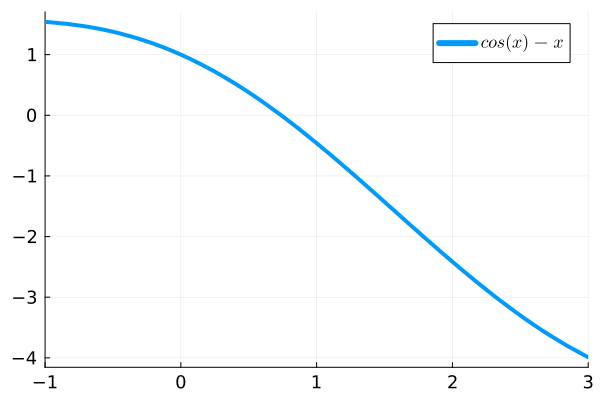

In [3]:
# Bisection algorithm from last time
f(x) = cos(x) - x

hasroot(f, a, b) = f(a) * f(b) < 0

function bisect_iter(f, a, b, tol)
    hist = Float64[]
    while abs(b - a) > tol
        mid = (a + b) / 2
        push!(hist, mid)
        if hasroot(f, a, mid)
            b = mid
        else
            a = mid
        end
    end
    hist
end

plot(f, xlims=[-1, 3], label="\$cos(x) - x\$")

In [4]:
# How many steps does this take?
length(bisect_iter(f, -1, 3, 1e-20))

56

### How fast does the error decrease?

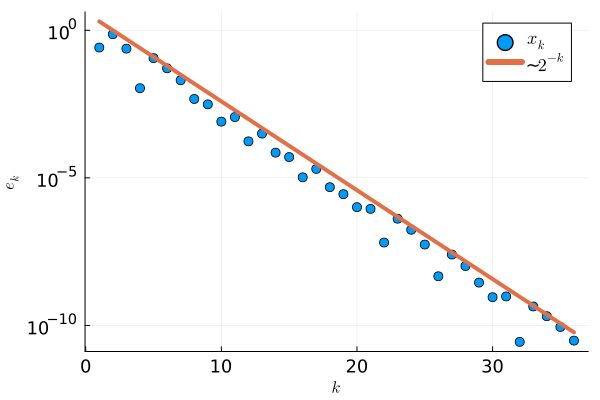

In [5]:
a = -1
b = 3
r = bisect_iter(f, a, b, 1e-15)[end] # is this a good 'true' root?

hist = bisect_iter(f, a, b, 1e-10)
# Recall the importance of using log-linear axes
scatter(abs.(hist .- r), yscale=:log10, label="\$x_k\$")

ks = 1:length(hist)
plot!(ks, (b - a) * (0.5 .^ ks), xlabel="\$k\$", ylabel="\$e_k\$", label="~\$2^{-k}\$")

So the error $e_k = x_k - x_*$ satisfies the bound

$$ \left\lvert e_k \right\rvert \leq c 2^{-k} $$

## Convergence classes

A convergent rootfinding algorithm produces a sequence of approximations $x_k$ such that

$$ \lim_{k \rightarrow \infty} x_k \rightarrow x_* $$

where $f \left( x_* \right) = 0$.
For analysis, it is convenient to define the errors $e_k = x_k - x_*$. We say that an iterative algorithm is **$q$-linearly convergent** if

$$ \lim_{k \rightarrow \infty} \lvert e_{k + 1} \rvert / \lvert e_k \rvert = \rho < 1 $$

(**$q$** stands for "quotient")
A smaller convergence factor $\rho$ represents faster convergence.

A slightly weaker condition, $r$-linear convergence or **linear convergence**, is that


$$ \lvert e_{k + 1} \rvert \leq \lvert e_k \rvert $$

for all sufficiently large $k$ when the sequence $\left\lbrace e_k \right\rbrace$ converges $q$-linearly to 0.

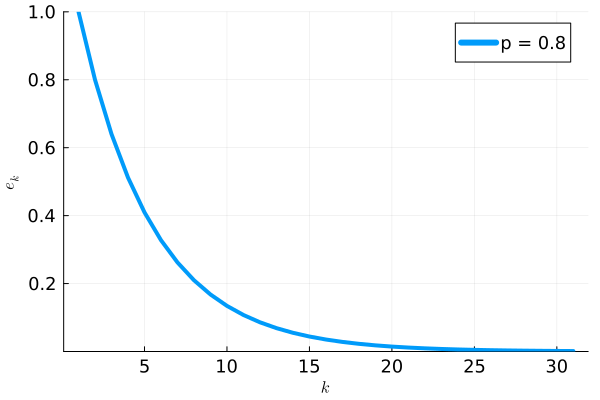

In [6]:
# Let's plot the error vs iterate for perfect q-linear convergence
ρ = 0.8
errors = [1.]
for i in 1:30
    next_e = errors[end] * ρ
    push!(errors, next_e)
end

plot(errors, ylims=(1e-10, 1), xlabel="\$k\$", ylabel="\$e_k\$", label="p = 0.8")

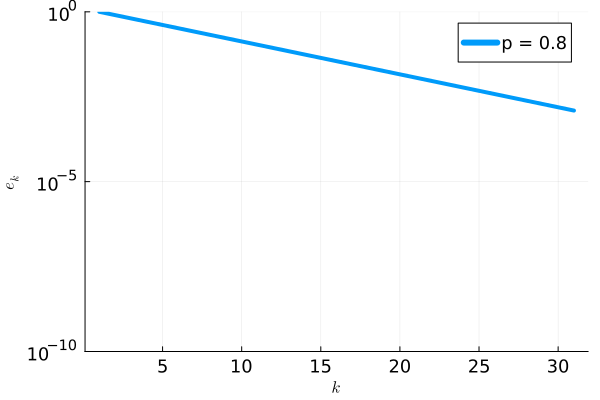

In [7]:
# Note the log scale on the plots make this easier to understand
plot(errors, yscale=:log10, ylims=(1e-10, 1), xlabel="\$k\$", ylabel="\$e_k\$", label="p = 0.8")

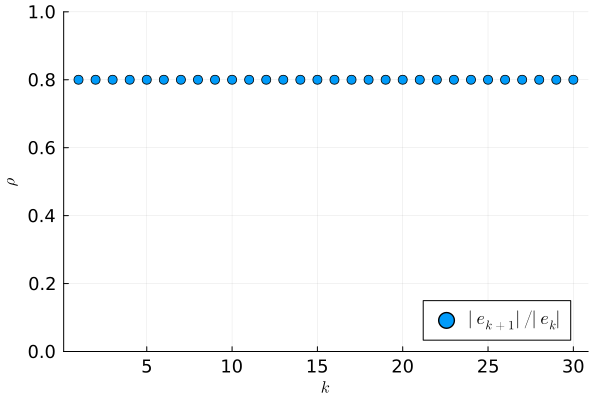

In [8]:
# The ratio of errors remains constant - q-linear
e = hist .- r

scatter(abs.(errors[2:end] ./ errors[1:end-1]), ylims=(0,1), xlabel="\$k\$", ylabel="\$\\rho\$", label="\$|e_{k+1}|/|e_k|\$")

### What about bisection

Is bisection

a) $q$-linearly convergent

b) $r$-linearly convergent

c) neither

Note

* Specifying an interval is often inconvenient

* An interval in which the function changes sign guarantees convergence (robustness)

* No derivative information is required

* If bisection works for $f \left( x \right)$, then it works and gives the same accuracy for $f \left( x \right) \sigma \left( x \right)$ where $\sigma \left( x \right) > 0$

* Roots of even degree are problematic

* A bound on the solution error is directly available

* The convergence rate is modest - one iteration per bit of accuracy

## Newton-Raphson method

Much of numerical analysis is based on [Taylor series](https://en.wikipedia.org/wiki/Taylor_series), the approximation

$$ f \left( x \right) = f \left( x_0 \right) + f' \left( x_0 \right) \left( x - x_0 \right) + f'' \left( x_0 \right) \left( x - x_0 \right)^2 / 2 + \cdots $$

centered on some reference point $\left( x_0 \right)$.

(Note - how big are the terms in my $\cdots$ above?)

In numerical computation, it is exceedingly rare to look beyond the first-order approximation

$$ \tilde{f}_{x_0} \left( x \right) = f \left( x_0 \right) + f' \left( x_0 \right) \left( x - x_0 \right) $$

Since $\tilde{f}_{x_0} \left( x \right)$ is a linear function, we can explicitly compute the unique solution of $\tilde{f}_{x_0} \left( x \right) = 0$ as $x = x_0 - f \left( x_0 \right) / f' \left( x_0 \right)$.

This is Newton’s Method (aka Newton-Raphson or Newton-Raphson-Simpson) for finding the roots of differentiable functions.

In [9]:
using Printf

function newton(f, fp, x0; tol=1e-8, verbose=false)
    x = x0
    for k in 1:100 # max number of iterations
        fx = f(x)
        fpx = fp(x)
        if verbose
            println("k=$k, x_k=$(@sprintf("%.16f", x)), f_k=$(@sprintf("%.16e", fx))")
        end
        if abs(fx) < tol
            return x, fx, k
        end
        x = x - fx / fpx
    end  
end

f(x) = cos(x) - x
fp(x) = -sin(x) - 1
newton(f, fp, 1; tol=1e-15, verbose=true)

k=1, x_k=1.0000000000000000, f_k=-4.5969769413186023e-01
k=2, x_k=0.7503638678402439, f_k=-1.8923073822117442e-02
k=3, x_k=0.7391128909113617, f_k=-4.6455898990771516e-05
k=4, x_k=0.7390851333852840, f_k=-2.8472058044570758e-10
k=5, x_k=0.7390851332151607, f_k=0.0000000000000000e+00


(0.7390851332151607, 0.0, 5)